<a href="https://colab.research.google.com/github/veapasichnyk/Applied-Data-Science-Capstone/blob/main/HW_2_4_%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B8_%D0%B1%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3%D1%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [2]:
raw_df = pd.read_csv("train.csv")

In [3]:
raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [4]:
train_df, val_df = split_train_val(raw_df, target_col="Exited")
print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)

Train shape: (12000, 14)
Val shape: (3000, 14)


In [5]:
input_cols = [col for col in train_df.columns if col not in ['Exited', 'CustomerId', 'Surname', 'id']]


1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [6]:
# Визначаємо категоріальні ознаки
categorical_cols = [col for col in input_cols if train_df[col].dtype == 'object']

# Застосовуємо перетворення
for col in categorical_cols:
    train_df[col] = train_df[col].astype('category')
    val_df[col] = val_df[col].astype('category')

In [7]:
X_train, y_train = separate_inputs_targets(train_df, input_cols, target_col="Exited")
X_val, y_val = separate_inputs_targets(val_df, input_cols, target_col="Exited")

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [8]:
!pip install xgboost --quiet

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [11]:
model = XGBClassifier(
    tree_method='hist',           # обов'язково для категоріальних ознак
    enable_categorical=True,      # увімкнути підтримку category dtype
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    device='cuda'
)

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:47:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [12]:
# Отримання ймовірностей класу 1
y_train_proba = model.predict_proba(X_train)[:, 1]
y_val_proba = model.predict_proba(X_val)[:, 1]

# AUROC
train_auc = roc_auc_score(y_train, y_train_proba)
val_auc = roc_auc_score(y_val, y_val_proba)

print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")

Train AUROC: 0.9432
Validation AUROC: 0.9371


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [16:47:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


**Спостереження**

Якість моделі — дуже висока, так як значення AUROC > 0.93 на обох наборах. Також маємо дуже малу різницю між train і val (~0.0061) - це означає, що модель не перенавчилась і має низький variance. Val AUROC (0.9371) — висока, отже маємо low bias.

Порівняно з Decision Tree AUROC покращено з 0.8911 до 0.9371.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [13]:
!pip install -U hyperopt

In [14]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [15]:
#Простір гіперпараметрів

space = {
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'n_estimators': hp.choice('n_estimators', [50, 100, 150]),
    'gamma': hp.uniform('gamma', 0, 5),
}

In [16]:
#Objective-функція

def objective(params):
    model = XGBClassifier(
        tree_method='hist',
        enable_categorical=True,
        device='cuda',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        **params
    )

    model.fit(X_train, y_train)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_val_proba)

    return {'loss': -val_auc, 'status': STATUS_OK}

In [17]:
#Запуск пошуку

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)

  5%|▌         | 1/20 [00:00<00:02,  6.61trial/s, best loss: -0.9374518142533782]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 10%|█         | 2/20 [00:00<00:02,  6.04trial/s, best loss: -0.9374518142533782]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 20%|██        | 4/20 [00:00<00:02,  5.39trial/s, best loss: -0.9374518142533782]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 30%|███       | 6/20 [00:01<00:02,  5.41trial/s, best loss: -0.9374518142533782]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 35%|███▌      | 7/20 [00:01<00:02,  5.63trial/s, best loss: -0.9374518142533782]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 45%|████▌     | 9/20 [00:01<00:02,  5.24trial/s, best loss: -0.9374518142533782]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 55%|█████▌    | 11/20 [00:01<00:01,  5.90trial/s, best loss: -0.9377714520886206]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 65%|██████▌   | 13/20 [00:02<00:01,  6.32trial/s, best loss: -0.9377714520886206]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 70%|███████   | 14/20 [00:02<00:00,  6.16trial/s, best loss: -0.9377714520886206]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 85%|████████▌ | 17/20 [00:02<00:00,  6.27trial/s, best loss: -0.9377714520886206]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 95%|█████████▌| 19/20 [00:03<00:00,  6.10trial/s, best loss: -0.9377714520886206]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



100%|██████████| 20/20 [00:03<00:00,  5.74trial/s, best loss: -0.9377714520886206]


In [18]:
depth_options = [3, 4, 5, 6]
n_estimators_options = [50, 100, 150]

best['max_depth'] = depth_options[best['max_depth']]
best['n_estimators'] = n_estimators_options[best['n_estimators']]

print("Best hyperparameters:")
print(best)

Best hyperparameters:
{'colsample_bytree': np.float64(0.8847877779020428), 'gamma': np.float64(4.457724062996729), 'learning_rate': np.float64(0.08766419912004804), 'max_depth': 3, 'n_estimators': 150, 'subsample': np.float64(0.8035111764466413)}


In [19]:
#Створення та навчання фінальної моделі
final_clf = XGBClassifier(
    tree_method='hist',
    enable_categorical=True,
    device='cuda',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    **best
)

final_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.8847877779020428), device='cuda',
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(4.457724062996729), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.08766419912004804), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
#Оцінка фінальної моделі (AUROC)
y_train_proba = final_clf.predict_proba(X_train)[:, 1]
y_val_proba = final_clf.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, y_train_proba)
val_auc = roc_auc_score(y_val, y_val_proba)

print(f"Final Train AUROC: {train_auc:.4f}")
print(f"Final Validation AUROC: {val_auc:.4f}")

Final Train AUROC: 0.9415
Final Validation AUROC: 0.9378


**Спостереження**

Модель з Hyperopt показала майже ті самі результати щой ручна Validation AUROC та Train AUROC:

  Було:

  -Train AUROC: 0.9432
  
  -Validation AUROC: 0.9371

  Стало:

  -Final Train AUROC: 0.9415

-Final Validation AUROC: 0.9378

Отже, hyperopt допоміг знайти адекватну модель і дещо покращити результат на Validation.



4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [21]:
!pip install lightgbm --quiet

In [22]:
import lightgbm as lgb

In [23]:
# Отримуємо індекси категоріальних колонок
cat_feature_indexes = [X_train.columns.get_loc(col) for col in categorical_cols]

In [24]:
#Створюємо lgbm-модель
lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [25]:
# Навчаємо модель
lgbm_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    categorical_feature=cat_feature_indexes
)

[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(colsample_bytree=0.8, max_depth=3, objective='binary',
               random_state=42, subsample=0.8)

In [26]:
#Оцінка якості за AUROC
y_train_proba = lgbm_model.predict_proba(X_train)[:, 1]
y_val_proba = lgbm_model.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, y_train_proba)
val_auc = roc_auc_score(y_val, y_val_proba)

print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")

Train AUROC: 0.9436
Validation AUROC: 0.9373


**Спостереження**

Хороший результат:

Train AUROC: 0.9436

Validation AUROC: 0.9373

Отже, LightGBM добре адаптувався до структури даних.

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [27]:
#Простір гіперпараметрів для LightGBM
space_lgbm = {
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'n_estimators': hp.choice('n_estimators', [50, 100, 150]),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
}

In [28]:
#Універсальна objective-функція для AUROC
def make_objective(model_class, fixed_params: dict = {}):
    def objective(params):
        # Комбінуємо параметри
        full_params = {**params, **fixed_params}

        model = model_class(**full_params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            categorical_feature=cat_feature_indexes,
            callbacks=[lgb.log_evaluation(0)]  # без логів
        )

        y_val_pred = model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_pred)
        return {'loss': -val_auc, 'status': STATUS_OK}

    return objective

In [29]:
#Запуск Hyperopt на 10 ітерацій

trials = Trials()

best_lgbm = fmin(
    fn=make_objective(lgb.LGBMClassifier, {'objective': 'binary', 'random_state': 42}),
    space=space_lgbm,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials
)

[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of te

In [30]:
depth_options = [3, 4, 5, 6]
n_estimators_options = [50, 100, 150]

best_lgbm['max_depth'] = depth_options[best_lgbm['max_depth']]
best_lgbm['n_estimators'] = n_estimators_options[best_lgbm['n_estimators']]

In [31]:
print("Best LightGBM hyperparameters:")
print(best_lgbm)

Best LightGBM hyperparameters:
{'colsample_bytree': np.float64(0.7535737519703755), 'learning_rate': np.float64(0.0633531445622308), 'max_depth': 3, 'min_child_weight': np.float64(1.0976088066322354), 'n_estimators': 150, 'reg_alpha': np.float64(0.22664699711097225), 'reg_lambda': np.float64(0.7453450274492242), 'subsample': np.float64(0.863414420178334)}


In [32]:
#Навчання фінальної моделі
final_lgb_clf = lgb.LGBMClassifier(
    objective='binary',
    random_state=42,
    **best_lgbm
)

final_lgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    categorical_feature=cat_feature_indexes,
    callbacks=[lgb.log_evaluation(0)]
)

[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(colsample_bytree=np.float64(0.7535737519703755),
               learning_rate=np.float64(0.0633531445622308), max_depth=3,
               min_child_weight=np.float64(1.0976088066322354),
               n_estimators=150, objective='binary', random_state=42,
               reg_alpha=np.float64(0.22664699711097225),
               reg_lambda=np.float64(0.7453450274492242),
               subsample=np.float64(0.863414420178334))

In [33]:
#Оцінка якості з AUROC
y_train_pred = final_lgb_clf.predict_proba(X_train)[:, 1]
y_val_pred = final_lgb_clf.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred)
val_auc = roc_auc_score(y_val, y_val_pred)

print(f"Final Train AUROC: {train_auc:.4f}")
print(f"Final Validation AUROC: {val_auc:.4f}")

Final Train AUROC: 0.9429
Final Validation AUROC: 0.9375


**Cпостереження**

LightGBM з Hyperopt -

Val AUROC = 0.9375 - вища за ручну LightGBM 0.9373

Train AUROC = 0.9429

Hyperopt з 10 ітерацій — уже ефективний, навіть із малою сіткою параметрів.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

**Експеримент**

Для submission на Kaggle спробую розширити простір гіперпараметрів і запустити Hyperopt з max_evals=30. Це дає змогу дослідити більше комбінацій і, можливо, знайти ще кращу модель.

In [47]:
# Категоріальні ознаки
categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')
cat_feature_indexes = [X_train.columns.get_loc(col) for col in categorical_cols]

In [48]:
# Простір гіперпараметрів
space_lgbm_v2 = {
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6, 7]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': hp.choice('n_estimators', [100, 150, 200]),
    'num_leaves': hp.quniform('num_leaves', 20, 100, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 10, 100, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.6, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1.0),
    'bagging_freq': hp.choice('bagging_freq', [1, 5, 10]),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
}

In [49]:
# Objective-функція
def make_objective_v2(model_class, fixed_params: dict = {}):
    def objective(params):
        # Кастинг типів
        params['num_leaves'] = int(params['num_leaves'])
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])

        full_params = {**params, **fixed_params}

        model = model_class(**full_params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            categorical_feature=cat_feature_indexes,
            callbacks=[lgb.log_evaluation(0)]
        )

        y_val_pred = model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_pred)
        return {'loss': -val_auc, 'status': STATUS_OK}

    return objective

In [50]:
# Запуск Hyperopt
trials = Trials()

best_lgbm_v2 = fmin(
    fn=make_objective_v2(lgb.LGBMClassifier, {'objective': 'binary', 'random_state': 42}),
    space=space_lgbm_v2,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

Показано результат, скорочений до останніх рядків (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [51]:
# Розкодування категорій + кастинг
best_lgbm_v2['max_depth'] = [3, 4, 5, 6, 7][best_lgbm_v2['max_depth']]
best_lgbm_v2['n_estimators'] = [100, 150, 200][best_lgbm_v2['n_estimators']]
best_lgbm_v2['bagging_freq'] = [1, 5, 10][best_lgbm_v2['bagging_freq']]
best_lgbm_v2['num_leaves'] = int(best_lgbm_v2['num_leaves'])
best_lgbm_v2['min_data_in_leaf'] = int(best_lgbm_v2['min_data_in_leaf'])

print("📊 Best hyperparameters found:")
print(best_lgbm_v2)

📊 Best hyperparameters found:
{'bagging_fraction': np.float64(0.7659716124084718), 'bagging_freq': 5, 'feature_fraction': np.float64(0.6213790709576795), 'learning_rate': np.float64(0.03933854613443927), 'max_depth': 4, 'min_data_in_leaf': 21, 'n_estimators': 150, 'num_leaves': 100, 'reg_alpha': np.float64(0.0010414521298306445), 'reg_lambda': np.float64(0.8173954984650271)}


In [52]:
# Навчання фінальної моделі
final_lgb_clf_v2 = lgb.LGBMClassifier(
    objective='binary',
    random_state=42,
    **best_lgbm_v2
)

In [53]:
final_lgb_clf_v2.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    categorical_feature=cat_feature_indexes,
    callbacks=[lgb.log_evaluation(0)]
)

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6213790709576795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6213790709576795
[LightGBM] [Warning] bagging_fraction is set=0.7659716124084718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659716124084718
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6213790709576795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6213790709576795
[LightGBM] [Warning] bagging_fraction is set=0.7659716124084718, subsample=1.0 will b

LGBMClassifier(bagging_fraction=np.float64(0.7659716124084718), bagging_freq=5,
               feature_fraction=np.float64(0.6213790709576795),
               learning_rate=np.float64(0.03933854613443927), max_depth=4,
               min_data_in_leaf=21, n_estimators=150, num_leaves=100,
               objective='binary', random_state=42,
               reg_alpha=np.float64(0.0010414521298306445),
               reg_lambda=np.float64(0.8173954984650271))

In [54]:
# Оцінка моделі
y_train_pred = final_lgb_clf_v2.predict_proba(X_train)[:, 1]
y_val_pred = final_lgb_clf_v2.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred)
val_auc = roc_auc_score(y_val, y_val_pred)

print(f"\n Final Train AUROC: {train_auc:.4f}")
print(f" Final Validation AUROC: {val_auc:.4f}")

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6213790709576795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6213790709576795
[LightGBM] [Warning] bagging_fraction is set=0.7659716124084718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659716124084718
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6213790709576795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6213790709576795
[LightGBM] [Warning] bagging_fraction is set=0.7659716124084718, subsample=1.0 will b

**Спостереження**

LightGBM (50 evals) не дає приросту на валід. вибірці, тому поки що не буду використовувати її для змагання.



**У моєму випадку модель XGBoost + Hyperopt — найкраща для фінального сабміту (найвища AUROC на val 0.9378)**

In [63]:
#Завантажуємо тестові дані
test_df = pd.read_csv('test.csv')

In [64]:
X_test = test_df[input_cols].copy()

In [65]:
for col in categorical_cols:
    if col in X_test.columns:
        X_test[col] = X_test[col].astype('category')

In [69]:
y_test_pred = final_clf.predict_proba(X_test)[:, 1]

In [70]:
#Зчитати шаблон для сабміту
submission_df = pd.read_csv("sample_submission.csv")

In [71]:
#Заповнити колонку Exited у шаблоні
submission_df["Exited"] = y_test_pred

In [72]:
submission_df.to_csv("submission.csv", index=False)

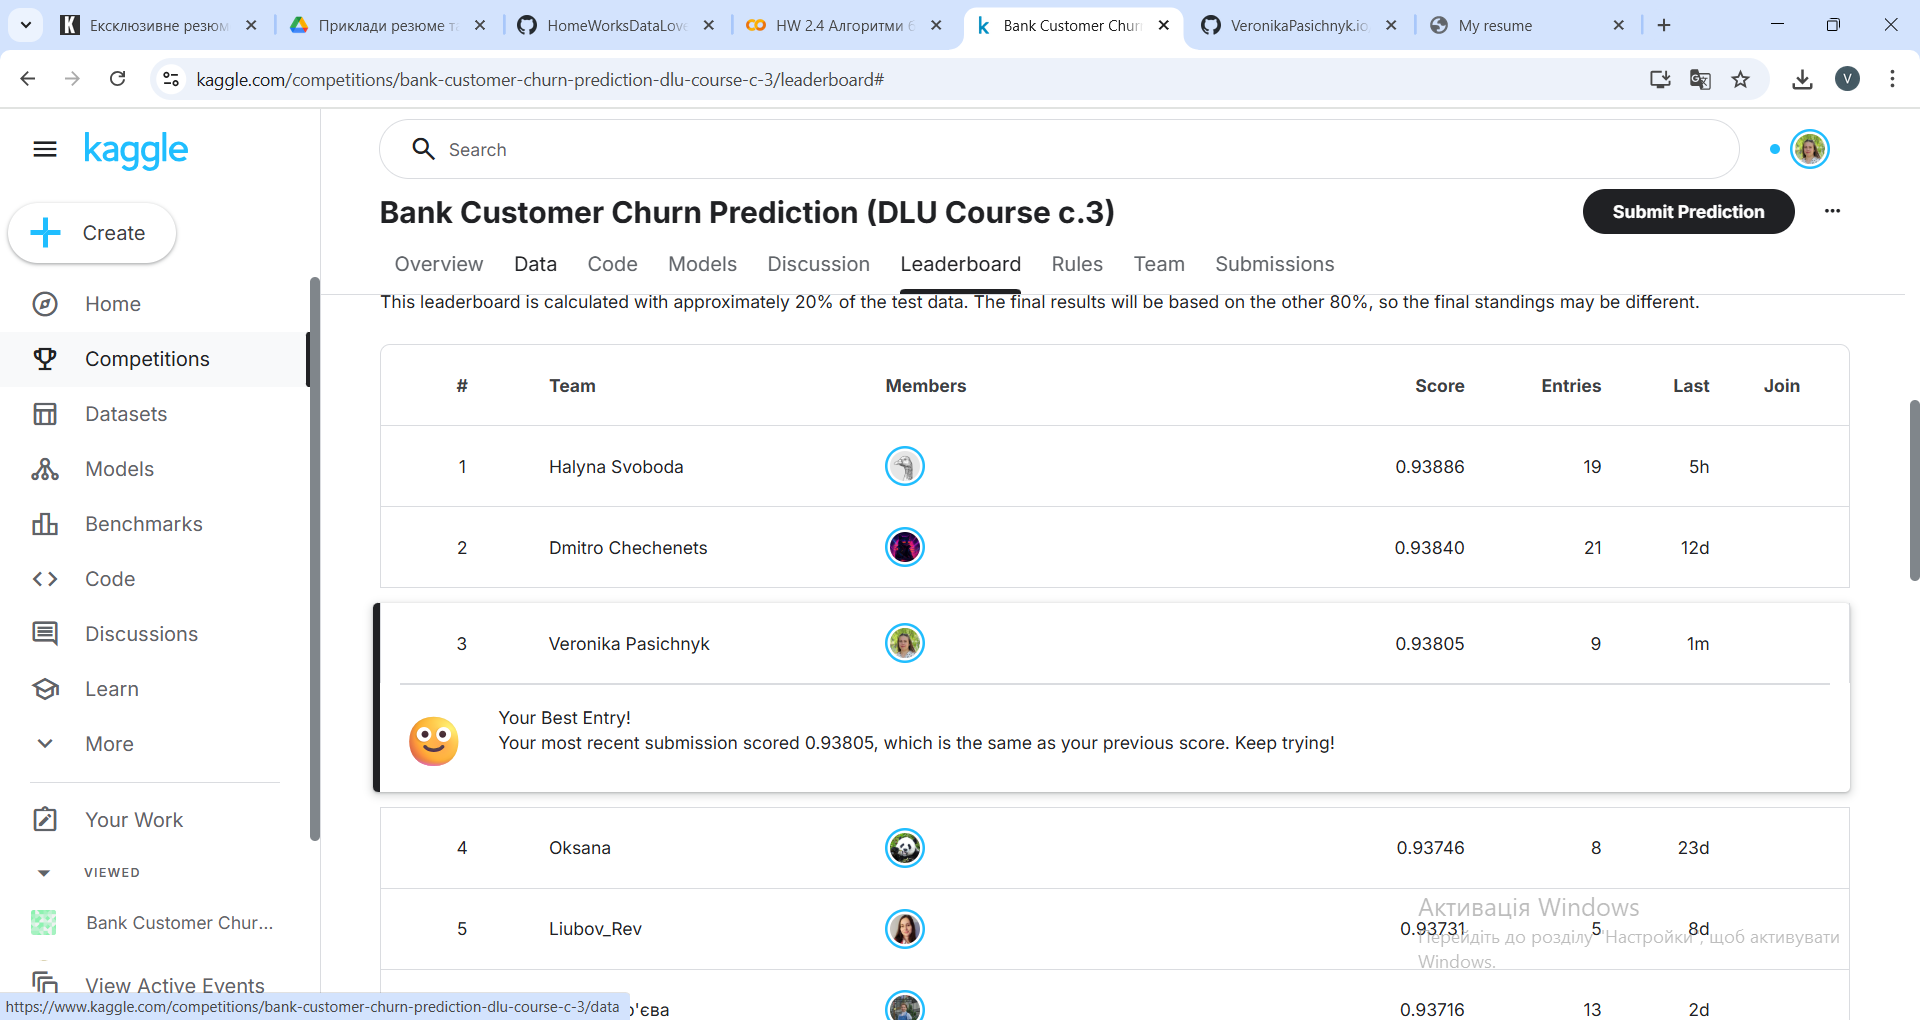